<a href="https://colab.research.google.com/github/FrederikBornemann/SyReAL/blob/main/notebooks/PySR_loss_21_09_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account).
2. (Optional) If you would like to do the deep learning component of this tutorial, turn on the GPU with Edit->Notebook settings->Hardware accelerator->GPU
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 3, 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Delete and disconnect runtime_ and repeat steps 2-4.

**Run the following code to install Julia**

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.2"
JULIA_PACKAGES="PyCall SymbolicRegression"
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"'
  done
  
  julia -e 'println("Success")'
fi

Streaming output truncated to the last 5000 lines.
  ◑ Adapt
  ◑ IteratorInterfaceExtensions
  ◓ DataAPI
  Progress [==========>                              ]  22/92
  ✓ IrrationalConstants
  ✓ RecipesBase
  ✓ ConstructionBase
  ◒ Adapt
  ◒ IteratorInterfaceExtensions
  ◑ DataAPI
  Progress [==========>                              ]  22/92
  ✓ IrrationalConstants
  ✓ RecipesBase
  ✓ ConstructionBase
  ◐ Adapt
  ◐ IteratorInterfaceExtensions
  ◒ DataAPI
  Progress [==========>                              ]  22/92
  ✓ IrrationalConstants
  ✓ RecipesBase
  ✓ ConstructionBase
  ◓ Adapt
  ◓ IteratorInterfaceExtensions
  ◐ DataAPI
  Progress [==========>                              ]  22/92
  ✓ IrrationalConstants
  ✓ RecipesBase
  ✓ ConstructionBase
  ◑ Adapt
  ◑ IteratorInterfaceExtensions
  ◓ DataAPI
  Progress [==========>                              ]  22/92
  ✓ IrrationalConstants
  ✓ RecipesBase
  ✓ ConstructionBase
  ◒ Adapt
  ◒ IteratorInterfaceExtensions
  ◑ DataAPI
  Progress

Install PySR and PyTorch-Lightning:

In [ ]:
%pip install -Uq pysr pytorch_lightning

The following step is not normally required, but colab's printing is non-standard and we need to manually set it up PyJulia:


In [ ]:
from julia import Julia

julia = Julia(compiled_modules=False)
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()


Let's install the backend of PySR, and all required libraries. We will also precompile them so they are faster at startup.

**(This may take some time)**

In [ ]:
import pysr

pysr.install()


In [ ]:
from sympy import *
from sympy import lambdify
from sympy import symbols
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#from pysr import PySRRegressor
from google.colab import files
import seaborn as sns
import pandas as pd
from ipywidgets import IntProgress
from IPython.display import display

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [ ]:
# enable latex text
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ['Tahoma', 'DejaVu Sans',
                               'Lucida Grande', 'Verdana'],
    "font.size": 14})

# Loss over random sample increase

#### Create a test data set

In [ ]:
np.random.seed(0)

N = 10000
xstart = 0
xstop = 2
upper_sigma = 2

def true_function(X, eps):
    try: 
        X = X[:,0]
    except:
        pass
    return 5 * np.cos(3.5 * X) - 1.3 + eps

X = (xstop-xstart) * np.random.rand(N, 5) + xstart      # produces X from xstart to xstop
sigma = np.random.rand(N) * (upper_sigma - 0.1) + 0.1
eps = sigma * np.random.randn(N)
y = true_function(X, eps)

test_set = pd.DataFrame({'x': X[:,0], 'y': y})
test_set.head

<bound method NDFrame.head of              x         y
0     1.097627 -4.843674
1     1.291788 -2.847091
2     1.583450  3.513668
3     0.174259  2.951862
4     1.957237  4.287097
...        ...       ...
9995  0.708121 -4.484062
9996  0.214065  2.519769
9997  0.511777 -2.683486
9998  1.301430 -2.090418
9999  1.092658 -4.811063

[10000 rows x 2 columns]>

In [ ]:
test_set.to_csv('test_set.csv')
files.download('test_set.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Loop


In [ ]:
# import test set
test_set = pd.read_csv('test_set.csv')

In [ ]:
test_set.head

<bound method NDFrame.head of       Unnamed: 0         x         y
0              0  1.097627 -4.843674
1              1  1.291788 -2.847091
2              2  1.583450  3.513668
3              3  0.174259  2.951862
4              4  1.957237  4.287097
...          ...       ...       ...
9995        9995  0.708121 -4.484062
9996        9996  0.214065  2.519769
9997        9997  0.511777 -2.683486
9998        9998  1.301430 -2.090418
9999        9999  1.092658 -4.811063

[10000 rows x 3 columns]>

In [ ]:
import random as rdm
import os

In [ ]:
array = np.array()

array = np.append(array, np.array([4,5,6]).reshape(-1,1), axis=1)
array

TypeError: ignored

In [ ]:
import random as rdm
import os
import numpy as np
import pandas as pd
from pysr import PySRRegressor
from itertools import permutations

# define first sample set
# fit with that
# evaluate all equations over linspace
# get all permuations of the differences of equations (add them?)
# search for maximum in diff curve
# add sample points at the area of maximum

# import test set
test_set = pd.read_csv('test_set.csv')

output_path='models_notrandom.csv'

rdm.seed(0)
steps = 2
samples = test_set.iloc[rdm.sample(range(test_set.shape[0]), 5)]

# outputs unique permutations
def unique_permutations(iterable, r=None):
    previous = tuple()
    for p in permutations(sorted(iterable), r):
        if p > previous:
            previous = p
            yield p

# define linspace for evaluating the equations
x_diff = np.linspace(0, 2, num=50).reshape(-1,1)

for i, n in enumerate(np.arange(5, 10, steps, dtype = int)):
    # sample from test set
    if i != 0:
        # calc all predictions
        for k in range(len(model.equations_)):
            if k == 0:
                predictions = model.predict(x_diff, index=k).reshape(-1,1)
            predictions = np.append(predictions, model.predict(x_diff, index=k).reshape(-1,1), axis=1)
        # get diff from every permutation:
        for idx, p in enumerate(unique_permutations(range(predictions.shape[1]), 2)):
            if idx == 0:
                differences = np.abs(predictions[:,p[0]]-predictions[:,p[1]]).reshape(-1,1)
            differences = np.append(differences, np.abs(predictions[:,p[0]]-predictions[:,p[1]]).reshape(-1,1), axis=1)
        # find max diff and map it on x_diff to get x value of max diff
        max_diff_x = x_diff[np.argmax(differences.sum(axis=1))]
        print(max_diff_x)
        # add new sample points to max diff area
        samples = samples.append(test_set.iloc[(test_set['x']-max_diff_x).abs().argsort()[:steps]])

    x = samples.x.to_numpy().reshape(-1,1)
    y = samples.y.to_numpy().reshape(-1,1)

    # fit model on sample
    model = PySRRegressor(
        niterations=20,
        populations=20,
        binary_operators=["plus", "mult"],
        unary_operators=["cos"],
        denoise=True,
        model_selection='best',
        select_k_features=1
        )
    model.fit(x, y)


    model.equations_["sample_size"] = pd.Series(n, index=range(model.equations_.score.shape[0]))
    model.equations_.to_csv(output_path, mode='a', header=not os.path.exists(output_path))


[2.]
Using features ['x0']


/usr/local/lib/python3.7/dist-packages/pysr/sr.py:1216: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  "Note: it looks like you are running in Jupyter. "
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Started!

Cycles per second: 3.140e+04
Head worker occupation: 1.4%
Progress: 87 / 400 total iterations (21.750%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           5.490e-01  -1.000e-10  -0.19095546
3           5.259e-02  1.173e+00  (x0 + -1.3120848)
6           1.858e-02  3.468e-01  (cos(x0 * x0) * -0.8640699)
7           1.575e-02  1.654e-01  cos(cos(x0 * x0) + 1.531174)
8           6.303e-03  9.157e-01  cos((x0 * (x0 + 0.39828175)) + 2.1196916)
9           2.744e-03  8.315e-01  cos((cos(x0 * x0) * x0) + 2.119691)
10          1.723e-03  4.656e-01  cos(((x0 * x0) + (x0 * 0.52437925)) + 2.0340383)
11          1.310e-03  2.738e-01  cos((cos(x0 * x0) * (x0 + -0.0701537)) + 2.1196916)
13          1.176e-03  5.393e-02  cos((cos(x0 * (x0 * 0.9984067)) * (x0 + -0.0701537)) + 2.1196916)
15          9.769e-04  9.276e-02  cos(cos(cos(cos(cos(x0)))) + ((cos(x0 * x0) * x0) + 1.342659))
17          8.482e-04  7.061e-02  cos(cos(cos(cos(co

/usr/local/lib/python3.7/dist-packages/pysr/sr.py:1216: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  "Note: it looks like you are running in Jupyter. "


Using features ['x0']


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/pysr/sr.py:1216: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  "Note: it looks like you are running in Jupyter. "


Using features ['x0']


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/pysr/sr.py:1216: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  "Note: it looks like you are running in Jupyter. "


Using features ['x0']


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/pysr/sr.py:1216: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  "Note: it looks like you are running in Jupyter. "


Using features ['x0']


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


# Targetted sampling

In [ ]:
import random as rdm
import os
import numpy as np
import pandas as pd
from pysr import PySRRegressor
from itertools import permutations

# define first sample set
# fit with that
# evaluate all equations over linspace
# get all permuations of the differences of equations (add them?)
# search for maximum in diff curve
# add sample points at the area of maximum
# fit with new samples

# import test set
test_set = pd.read_csv('test_set.csv')

output_path='models_notrandom.csv'
samples_output_path='samples_notrandom.csv' 

rdm.seed(0)
steps = 2
samples = test_set.iloc[rdm.sample(range(test_set.shape[0]), 5)]

# outputs unique permutations
def unique_permutations(iterable, r=None):
    previous = tuple()
    for p in permutations(sorted(iterable), r):
        if p > previous:
            previous = p
            yield p

# define linspace for evaluating the equations
x_diff = np.linspace(0, 2, num=50).reshape(-1,1)

for i, n in enumerate(np.arange(5, 105, steps, dtype = int)):
    # sample from test set
    if i != 0:
        # calc all predictions
        for k in range(len(model.equations_)):
            if k == 0:
                predictions = model.predict(x_diff, index=k).reshape(-1,1)
            predictions = np.append(predictions, model.predict(x_diff, index=k).reshape(-1,1), axis=1)
        # get diff from every permutation:
        for idx, p in enumerate(unique_permutations(range(predictions.shape[1]), 2)):
            if idx == 0:
                differences = np.abs(predictions[:,p[0]]-predictions[:,p[1]]).reshape(-1,1)
            differences = np.append(differences, np.abs(predictions[:,p[0]]-predictions[:,p[1]]).reshape(-1,1), axis=1)
        # find max diff and map it on x_diff to get x value of max diff
        max_diff_x = x_diff[np.argmax(differences.sum(axis=1))]
        print(max_diff_x)
        # add new sample points to max diff area
        samples = samples.append(test_set.iloc[(test_set['x']-max_diff_x).abs().argsort()[250:250+steps]], ignore_index = True)

    x = samples.x.to_numpy().reshape(-1,1)
    y = samples.y.to_numpy().reshape(-1,1)

    # fit model on sample
    model = PySRRegressor(
        niterations=20,
        populations=20,
        binary_operators=["plus", "mult"],
        unary_operators=["cos", "exp", "square"],
        denoise=True,
        model_selection='best',
        select_k_features=1
        )
    model.fit(x, y)

    # export samples
    saved_samples = samples.copy()
    saved_samples["sample_size"] = pd.Series(saved_samples.shape[0], index=range(saved_samples.shape[0]))
    saved_samples.to_csv(samples_output_path, mode='a', header=not os.path.exists(output_path))
    
    # export models
    model.equations_["sample_size"] = pd.Series(n, index=range(model.equations_.score.shape[0]))
    model.equations_.to_csv(output_path, mode='a', header=not os.path.exists(output_path))

# Random: Post-processing

In [ ]:
models = pd.read_csv('models.csv')

#### Evaluate loss on test set

In [ ]:
losses_random = pd.DataFrame({"sample_size": [], "equation": [], "loss": []})
x_con = np.linspace(xstart,xstop,500)
real_y_con = true_function(x_con, 0)

# fancy progress bar
f = IntProgress(min=0, max=len(models.sample_size.unique().tolist())) # instantiate the bar
display(f) # display the bar

for idx, n in enumerate(models.sample_size.unique().tolist()):
    equations = models.loc[models["sample_size"] == n].sympy_format
    for eq in equations:
        try:
            x0 = symbols('x0')
            lam_x = lambdify(x0, eq, modules=['numpy'])
            y_con = lam_x(x_con)
            loss = (np.square(y_con - real_y_con)).mean(axis=0)
        except:
            loss = (np.square(np.full(x_con.shape, eq) - real_y_con)).mean(axis=0)
        df = pd.DataFrame({"sample_size": [n], "equation": [eq], "loss": [loss]})
        losses_random = losses_random.append(df, ignore_index = True)
    f.value = idx
print("Done!")

Done!


#### Calculate the plot points

In [ ]:
loss_plot_random = pd.DataFrame({"sample_size": [], "min_loss": [], "mean_loss": [], "loss_err": []})

for n in losses.sample_size.unique().tolist():
    loss_list = np.array(losses.loc[losses['sample_size']==n,'loss'].tolist())

    df = pd.DataFrame({"sample_size": [n], "min_loss": [loss_list.min()], "max_loss": [loss_list.max()], "mean_loss": [loss_list.mean()], "loss_err": [loss_list.std()]})
    loss_plot_random = loss_plot_random.append(df, ignore_index = True)


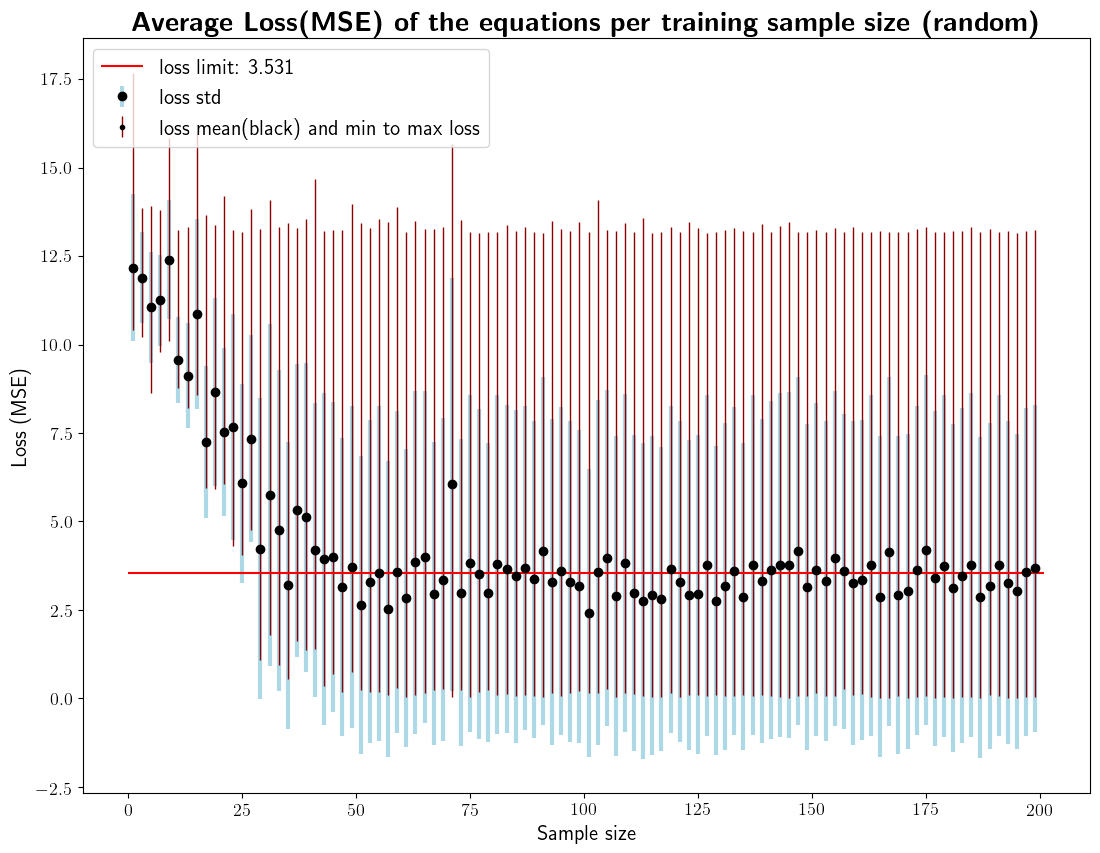

In [ ]:
x_lim = 100

convergence = np.array(loss_plot_random.mean_loss.tolist()[100:]).mean()


plt.figure(figsize=(13, 10), dpi= 100, facecolor='w', edgecolor='k')

mins = loss_plot_random.min_loss[:x_lim]
maxes = loss_plot_random.max_loss[:x_lim]
means = loss_plot_random.mean_loss[:x_lim]
std = loss_plot_random.loss_err[:x_lim]

plt.errorbar(loss_plot_random.sample_size.tolist()[:x_lim], means, std, fmt='ok', lw=3, ecolor="lightblue", label="loss std")
plt.errorbar(loss_plot_random.sample_size.tolist()[:x_lim], means, [means - mins, maxes - means], fmt='.k', ecolor='darkred', lw=1, label="loss mean(black) and min to max loss")
# plt.errorbar(loss_plot.sample_size.tolist()[:x_lim], loss_plot.mean_loss.tolist()[:x_lim], yerr=loss_plot.loss_err.tolist()[:x_lim], fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label="mean loss and variance")

plt.hlines(convergence, xmin=0, xmax=loss_plot_random.sample_size.tolist()[x_lim], color="red", label=f"loss limit: {round(convergence,3)}")

# legend modification
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
#handles = [h[0] for h in handles]
plt.rcParams['font.size'] = '16'
ax.legend(handles, labels, loc='upper left',numpoints=1,  fontsize=15)

plt.xlabel("Sample size", fontsize=15) 
plt.ylabel("Loss (MSE)", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.legend()
plt.title(r"\textbf{Average Loss(MSE) of the equations per training sample size (random)}", fontsize=20)
fig = plt.gcf()
plt.draw()
plt.show()  

In [ ]:
filename = f"loss_random_sampling{x_lim*2}_s{upper_sigma}.png"
fig.savefig(filename, dpi=150, bbox_inches='tight')
files.download(filename) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

It looks like the limit is reached with a sample size of $N=50$

Now let's look at the equations from that EquationSearch:

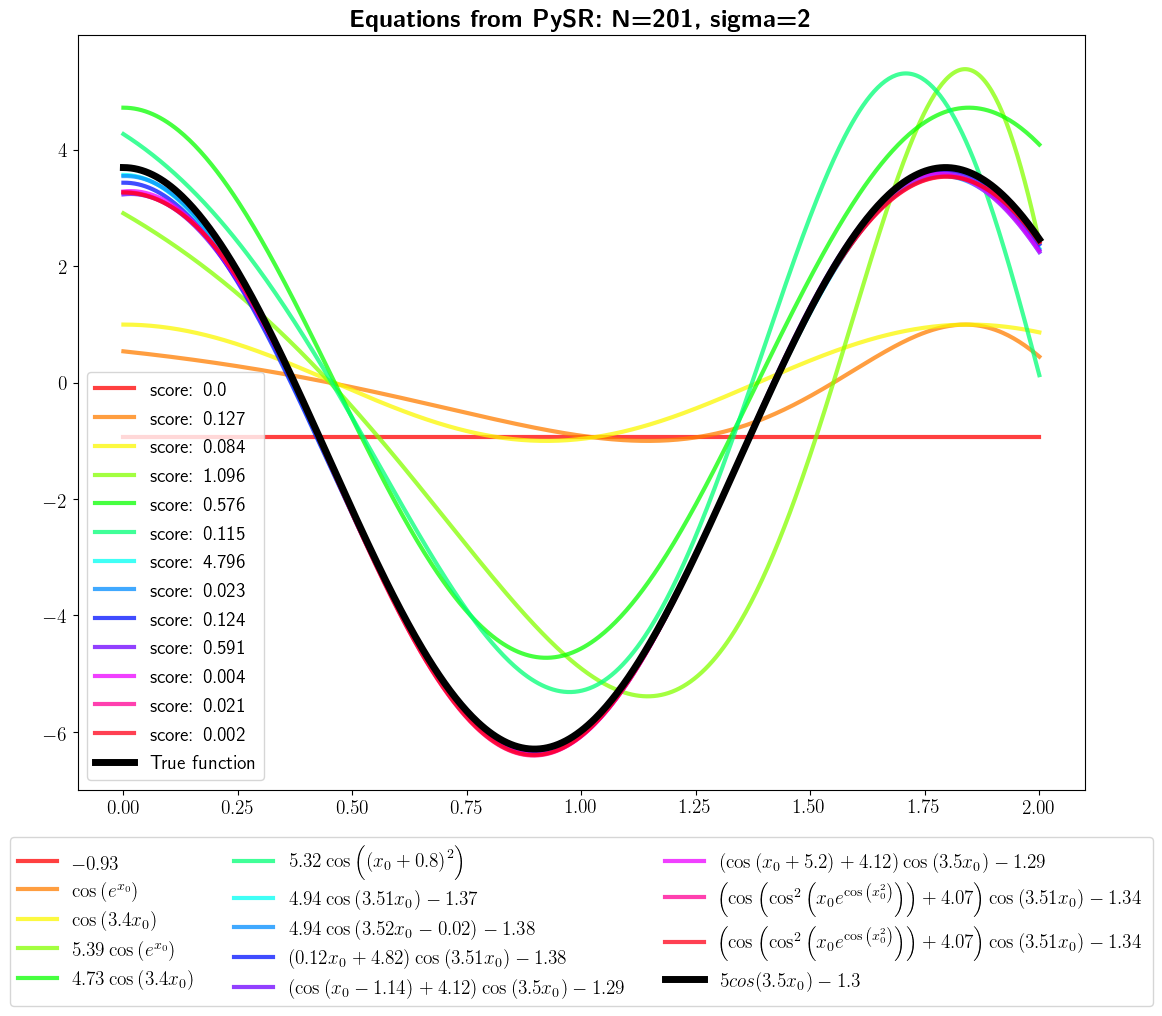

In [ ]:
plt.figure(figsize=(13, 10), dpi= 100, facecolor='w', edgecolor='k')

sample_size = 201
df = models.loc[models["sample_size"]==sample_size]

# plot input points
#plt.scatter(X[:,0], y, s=30, label="Input data", alpha=0.15, color="red")

# get number of equations
idx = len(df)

palette = cm.get_cmap('hsv', idx)

# plot every equation from the model
eq_list = []
lines = []
x_con = np.linspace(xstart,xstop,500)

for i, eq in enumerate(df.sympy_format.tolist()):
    eq = sympify(eq)
    # if best score => bold label
    preamble, endamble = ["", ""]
    if i == df.score.reset_index(drop=True).idxmax():
        preamble, endamble = ["\\textbf{", "}"]
    try:
        x0 = symbols('x0')
        lam_x = lambdify(x0, eq, modules=['numpy'])
        y_con = lam_x(x_con)
        line, = plt.plot(x_con, y_con, linewidth=3, label=f"{preamble}score: {round(df.score.iloc[i],3)}{endamble}", alpha=0.75, color=palette(i))
        lines.append(line)
    except:
        # some equations don't have a variable x0 and therefore are constants
        line, = plt.plot(x_con, np.full(x_con.shape, eq), alpha=0.75, color=palette(i),linewidth=3, label=f"{preamble}score: {round(df.score.iloc[i],3)}{endamble}")
        lines.append(line)
    
    # round parameters for legend
    
    for a in preorder_traversal(eq):
        if isinstance(a, Float):
            eq = eq.subs(a, round(a, 2))
    eq_list.append(f"${latex(sympify(eq))}$")

# plot true function
y_con = 5 * np.cos(3.5 * x_con) - 1.3
line, = plt.plot(x_con, y_con, linewidth=5, color="black", label="True function")
lines.append(line)
eq_list.append("$5cos(3.5x_0) - 1.3$")

legend1 = plt.legend(lines, eq_list, bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=3, fancybox=True)
plt.gca().add_artist(legend1)

plt.title(f"\\textbf{{Equations from PySR: N={sample_size}, sigma={upper_sigma}}}", fontsize=18)
plt.legend(loc=3)
fig = plt.gcf()
plt.draw()
plt.show()

# Targetted: Post-processing

In [ ]:
models_target = pd.read_csv('models_notrandom.csv')

#### Evaluate loss on test set

In [ ]:
losses = pd.DataFrame({"sample_size": [], "equation": [], "loss": []})
x_con = np.linspace(xstart,xstop,500)
real_y_con = true_function(x_con, 0)

# fancy progress bar
f = IntProgress(min=0, max=len(models_target.sample_size.unique().tolist())) # instantiate the bar
display(f) # display the bar

for idx, n in enumerate(models_target.sample_size.unique().tolist()):
    equations = models_target.loc[models_target["sample_size"] == n].sympy_format
    for eq in equations:
        try:
            x0 = symbols('x0')
            lam_x = lambdify(x0, eq, modules=['numpy'])
            y_con = lam_x(x_con)
            loss = (np.square(y_con - real_y_con)).mean(axis=0)
        except:
            loss = (np.square(np.full(x_con.shape, eq) - real_y_con)).mean(axis=0)
        df = pd.DataFrame({"sample_size": [n], "equation": [eq], "loss": [loss]})
        losses = losses.append(df, ignore_index = True)
    f.value = idx
print("Done!")

IntProgress(value=0, max=150)

Done!


#### Calculate the plot points

In [ ]:
loss_plot = pd.DataFrame({"sample_size": [], "min_loss": [], "mean_loss": [], "loss_err": []})

for n in losses.sample_size.unique().tolist():
    loss_list = np.array(losses.loc[losses['sample_size']==n,'loss'].tolist())

    df = pd.DataFrame({"sample_size": [n], "min_loss": [loss_list.min()], "max_loss": [loss_list.max()], "mean_loss": [loss_list.mean()], "loss_err": [loss_list.std()]})
    loss_plot = loss_plot.append(df, ignore_index = True)


In [ ]:
%matplotlib inline

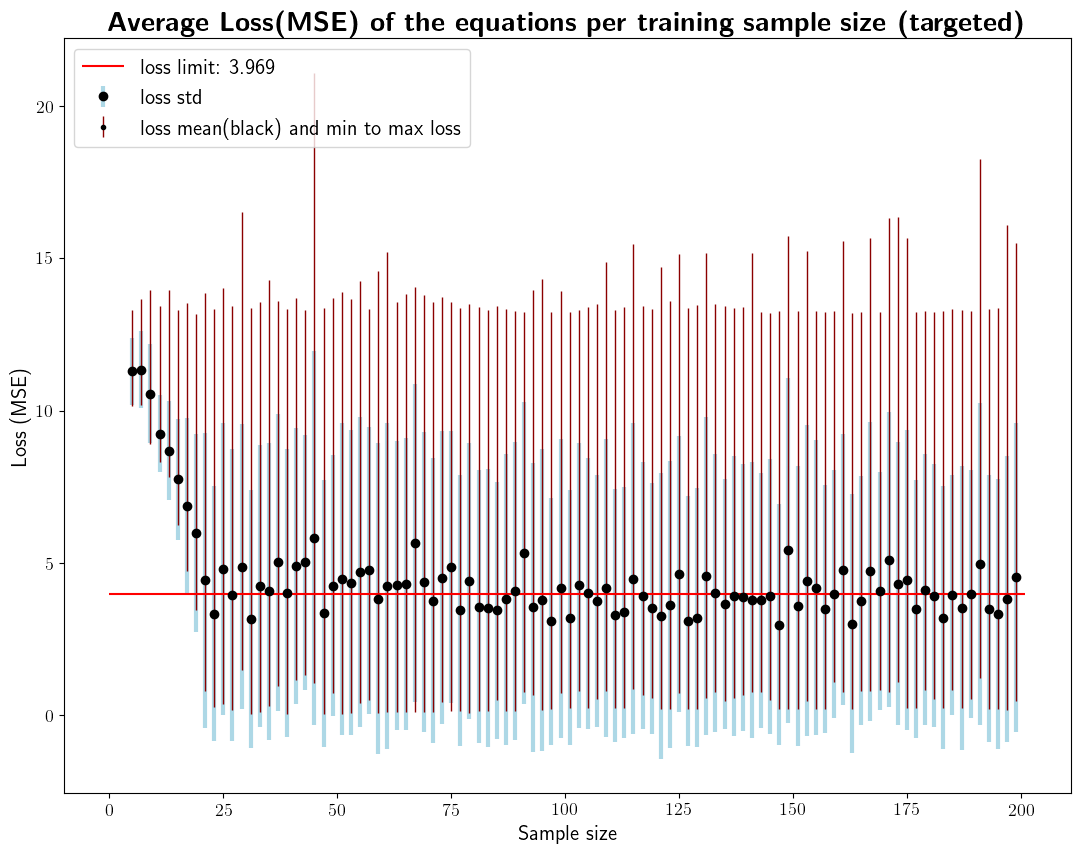

In [ ]:
x_lim = 98



convergence = np.array(loss_plot.mean_loss.tolist()[20:]).mean()


plt.figure(figsize=(13, 10), dpi= 100, facecolor='w', edgecolor='k')

mins = loss_plot.min_loss[:x_lim]
maxes = loss_plot.max_loss[:x_lim]
means = loss_plot.mean_loss[:x_lim]
std = loss_plot.loss_err[:x_lim]

plt.errorbar(loss_plot.sample_size.tolist()[:x_lim], means, std, fmt='ok', lw=3, ecolor="lightblue", label="loss std")
plt.errorbar(loss_plot.sample_size.tolist()[:x_lim], means, [means - mins, maxes - means], fmt='.k', ecolor='darkred', lw=1, label="loss mean(black) and min to max loss")
# plt.errorbar(loss_plot.sample_size.tolist()[:x_lim], loss_plot.mean_loss.tolist()[:x_lim], yerr=loss_plot.loss_err.tolist()[:x_lim], fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label="mean loss and variance")

plt.hlines(convergence, xmin=0, xmax=loss_plot.sample_size.tolist()[x_lim], color="red", label=f"loss limit: {round(convergence,3)}")

# legend modification
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
# handles = [h[0] for h in handles]

ax.legend(handles, labels, loc='upper left',numpoints=1, fontsize=15)

plt.xlabel("Sample size",fontsize=15) 
plt.ylabel("Loss (MSE)",fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.legend()
plt.title(r"\textbf{Average Loss(MSE) of the equations per training sample size (targeted)}",fontsize=20)
fig = plt.gcf()
plt.draw()
plt.show()  

In [ ]:
filename = f"loss_targeted_sampling{x_lim*2}_s{upper_sigma}.png"
fig.savefig(filename, dpi=150, bbox_inches='tight')
files.download(filename) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

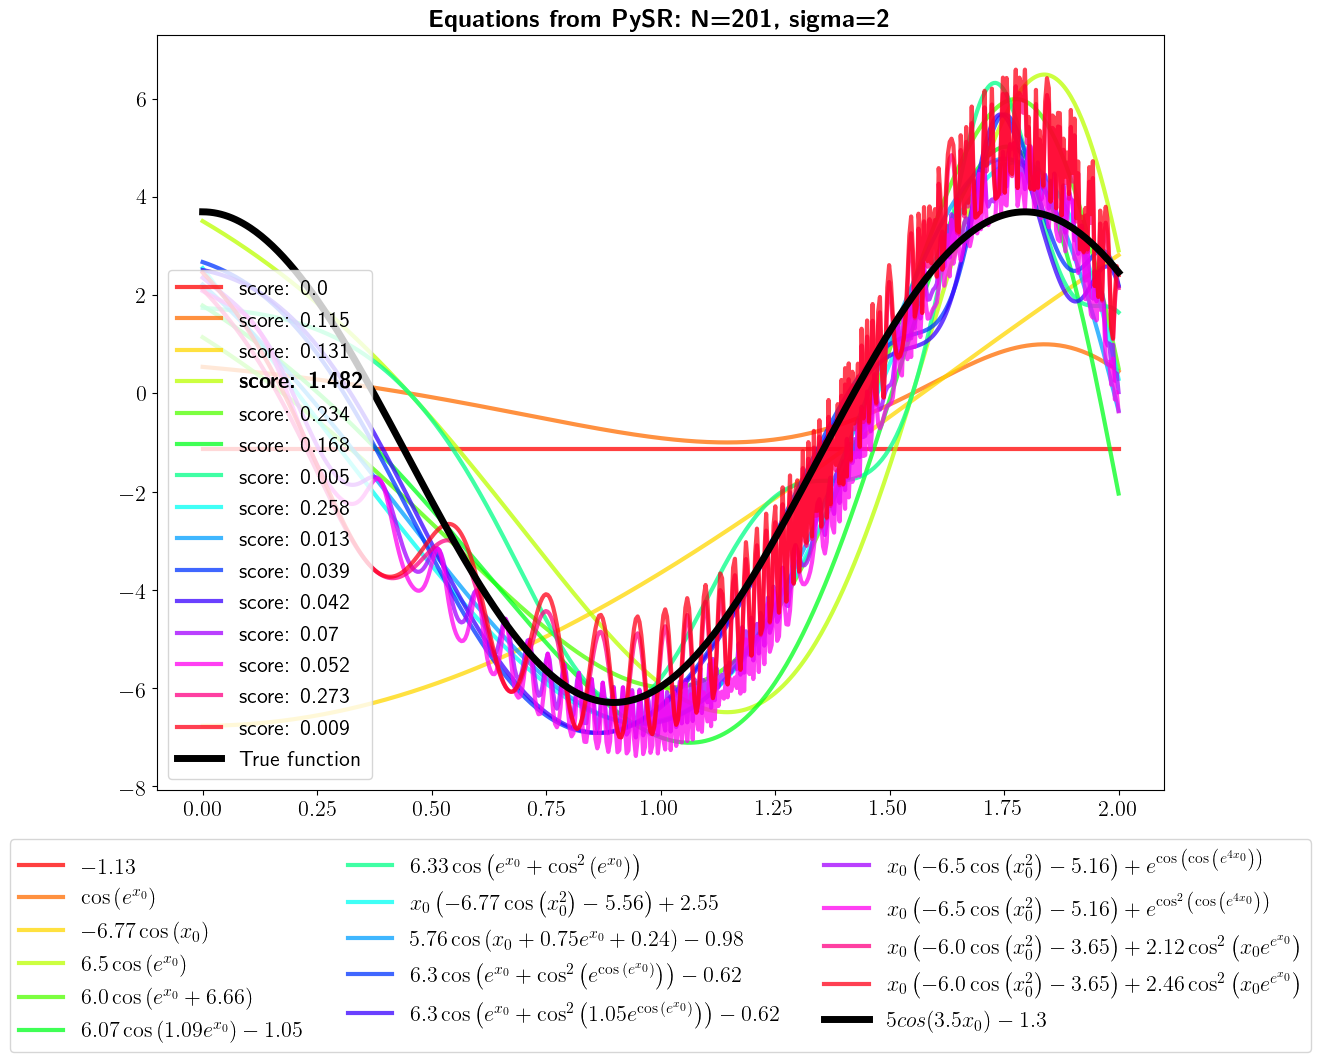

In [ ]:
plt.figure(figsize=(13, 10), dpi= 100, facecolor='w', edgecolor='k')

sample_size = 201
df = models_target.loc[models_target["sample_size"]==sample_size]

# plot input points
#plt.scatter(X[:,0], y, s=30, label="Input data", alpha=0.15, color="red")

# get number of equations
idx = len(df)

palette = cm.get_cmap('hsv', idx)

# plot every equation from the model
eq_list = []
lines = []
x_con = np.linspace(xstart,xstop,500)
print()
for i, eq in enumerate(df.sympy_format.tolist()):
    eq = sympify(eq)
    # if best score => bold label
    preamble, endamble = ["", ""]
    if i == df.score.reset_index(drop=True).idxmax():
        preamble, endamble = ["\\textbf{", "}"]
    try:
        x0 = symbols('x0')
        lam_x = lambdify(x0, eq, modules=['numpy'])
        y_con = lam_x(x_con)
        line, = plt.plot(x_con, y_con, linewidth=3, label=f"{preamble}score: {round(df.score.iloc[i],3)}{endamble}", alpha=0.75, color=palette(i))
        lines.append(line)
    except:
        # some equations don't have a variable x0 and therefore are constants
        line, = plt.plot(x_con, np.full(x_con.shape, eq), alpha=0.75, color=palette(i),linewidth=3, label=f"{preamble}score: {round(df.score.iloc[i],3)}{endamble}")
        lines.append(line)
    
    # round parameters for legend
    
    for a in preorder_traversal(eq):
        if isinstance(a, Float):
            eq = eq.subs(a, round(a, 2))
    eq_list.append(f"${latex(sympify(eq))}$")

# plot true function
y_con = 5 * np.cos(3.5 * x_con) - 1.3
line, = plt.plot(x_con, y_con, linewidth=5, color="black", label="True function")
lines.append(line)
eq_list.append("$5cos(3.5x_0) - 1.3$")

legend1 = plt.legend(lines, eq_list, bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=3, fancybox=True)
plt.gca().add_artist(legend1)

plt.title(f"\\textbf{{Equations from PySR: N={sample_size}, sigma={upper_sigma}}}", fontsize=18)
plt.legend(loc=3)
fig = plt.gcf()
plt.draw()
plt.show()

#### Animation of targetted sampling

In [ ]:
samples = pd.read_csv('samples_notrandom.csv')

In [ ]:
%matplotlib notebook
%matplotlib notebook

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [ ]:
ani_samples = samples.copy().drop_duplicates()
#print(ani_samples.x[:2].tolist())
fig, ax = plt.subplots()
line = ax.scatter([],[])     # A tuple unpacking to unpack the only plot
ax.set_xlim(0, 2)
ax.set_ylim(-5, 5)



def buildmebarchart(i=int):
    line.set_data((ani_samples.x[:i].tolist(), ani_samples.y[:i].tolist()))
    return line

import matplotlib.animation as ani
animator = ani.FuncAnimation(fig, buildmebarchart, frames=30, interval = 20)
plt.show()

<IPython.core.display.Javascript object>

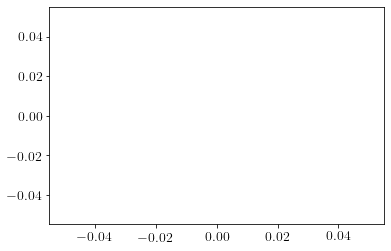

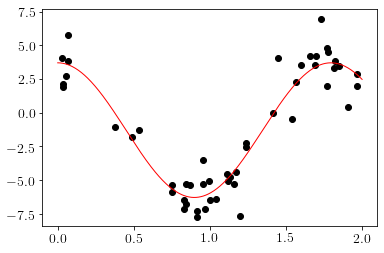

In [ ]:

from celluloid import Camera

x_con = np.linspace(xstart,xstop,500)
y_con = 5 * np.cos(3.5 * x_con) - 1.3


ani_samples = samples.copy().drop_duplicates(subset=['x', 'y']).reset_index(drop=True)
plt.plot()
camera = Camera(plt.figure())
for i in range(ani_samples.shape[0]):
    plt.plot(x_con, y_con, linewidth=1, color="red", label="True function")
    plt.scatter(ani_samples.x[:i], ani_samples.y[:i], color="black")
    camera.snap()
anim = camera.animate(blit=True)
anim.save('scatter.mp4')

In [ ]:
files.download('scatter.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install celluloid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Comparing the methods

In [ ]:
from scipy.interpolate import interp1d

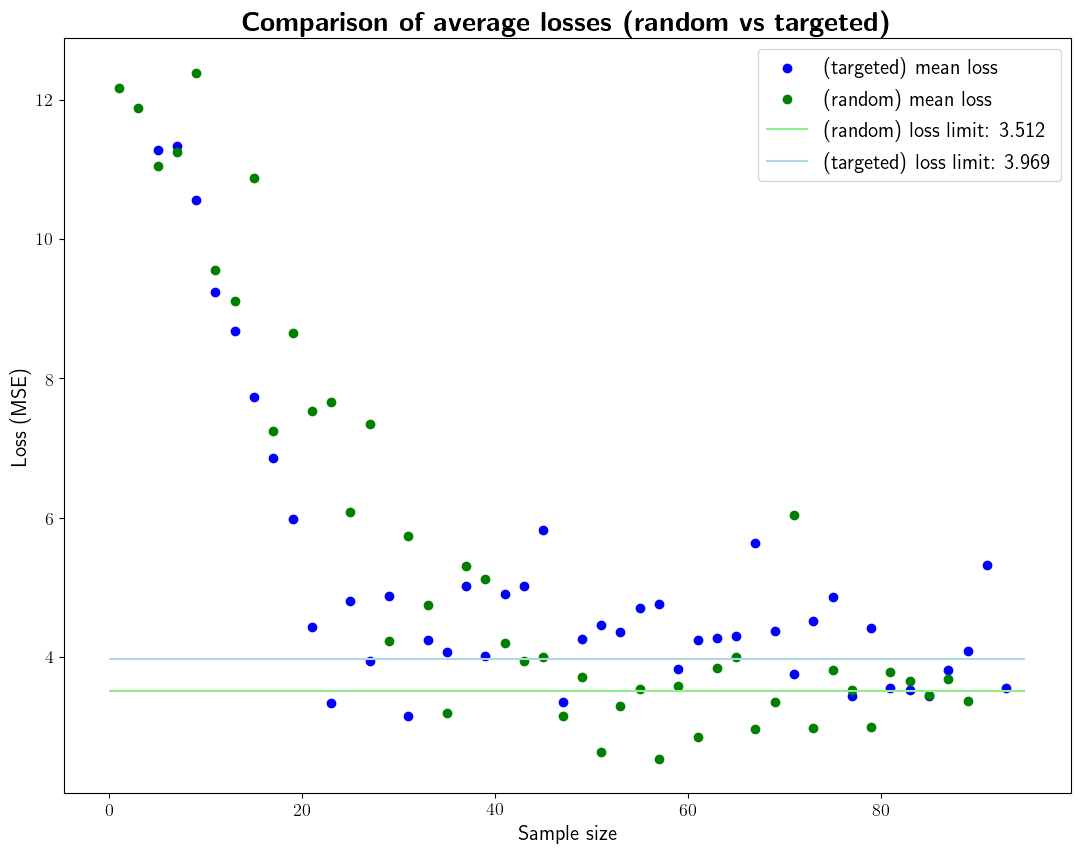

In [ ]:
x_lim = 45


convergence_random = np.array(loss_plot_random.mean_loss.tolist()[20:]).mean()
convergence = np.array(loss_plot.mean_loss.tolist()[20:]).mean()

plt.figure(figsize=(13, 10), dpi= 100, facecolor='w', edgecolor='k')

mins = loss_plot.min_loss[:x_lim]
maxes = loss_plot.max_loss[:x_lim]
means_random = loss_plot_random.mean_loss[:x_lim]
means = loss_plot.mean_loss[:x_lim]
std = loss_plot.loss_err[:x_lim]

plt.scatter(loss_plot.sample_size.tolist()[:x_lim], means, color="blue", label="(targeted) mean loss")
plt.scatter(loss_plot_random.sample_size.tolist()[:x_lim], means_random, color="green",label="(random) mean loss")
# plt.errorbar(loss_plot.sample_size.tolist()[:x_lim], loss_plot.mean_loss.tolist()[:x_lim], yerr=loss_plot.loss_err.tolist()[:x_lim], fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label="mean loss and variance")

# Define x, y, and xnew to resample at.

#xnew = np.linspace(0, 200, num=500, endpoint=True)

# Define interpolators.
#f_linear = interp1d(x, y)
#f_cubic = interp1d(loss_plot.sample_size.tolist()[:x_lim], means, kind='cubic', fill_value="extrapolate")

# Plot.
#plt.plot(x, y, 'o', label='data')
#plt.plot(xnew, f_linear(xnew), '-', label='linear')
#plt.plot(xnew, f_cubic(xnew), '--', label='cubic')

plt.hlines(convergence_random, xmin=0, xmax=loss_plot.sample_size.tolist()[x_lim], color="lightgreen", label=f"(random) loss limit: {round(convergence_random,3)}")
plt.hlines(convergence, xmin=0, xmax=loss_plot.sample_size.tolist()[x_lim], color="lightblue", label=f"(targeted) loss limit: {round(convergence,3)}")

# legend modification
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
# handles = [h[0] for h in handles]

ax.legend(handles, labels, loc='upper right',numpoints=1, fontsize=15)

plt.xlabel("Sample size",fontsize=15) 
plt.ylabel("Loss (MSE)",fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.legend()
plt.title(r"\textbf{Comparison of average losses (random vs targeted)}",fontsize=20)
fig = plt.gcf()
plt.draw()
plt.show()  

In [ ]:
filename = f"loss_comparison{x_lim*2}_s{upper_sigma}.png"
fig.savefig(filename, dpi=150, bbox_inches='tight')
files.download(filename) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>